# Natural Language Processing with Disaster Tweets

## 1. Introduction

In this competition, I will build a recurrent neural network model that predicts which Tweets are about real disasters and which one’s aren’t. 

I have access to a training dataset of 7,613 tweets that were hand classified. 3,263 tweets are in test dataset. Each training data point includes following features.

* id - a unique identifier for each tweet
* text - the text of the tweet
* location - the location the tweet was sent from (may be blank)
* keyword - a particular keyword from the tweet (may be blank)
* target - in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)

Note: keyword and location might be blank for some data point

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


## 2. Exploratory Data Analysis

In [2]:
# Define the data path
data_path = '/kaggle/input/nlp-getting-started'
train_path = os.path.join(data_path, 'train.csv')
test_path = os.path.join(data_path, 'test.csv')

df_train =  pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

In [3]:
# Displace the training data structure
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
# Displace the testing data structure
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [5]:
# Display the text length of train and test data
print('Train Data Size: ', len(df_train))
print('Test Data Size: ', len(df_test))

Train Data Size:  7613
Test Data Size:  3263


In [6]:
# Display an example text
df_train['text'][2]

"All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected"

#### Category Distribution of the Tweets. Zero indicates no real disaster and one indicates real disaster

In [7]:
df_train['target'].value_counts()

target
0    4342
1    3271
Name: count, dtype: int64

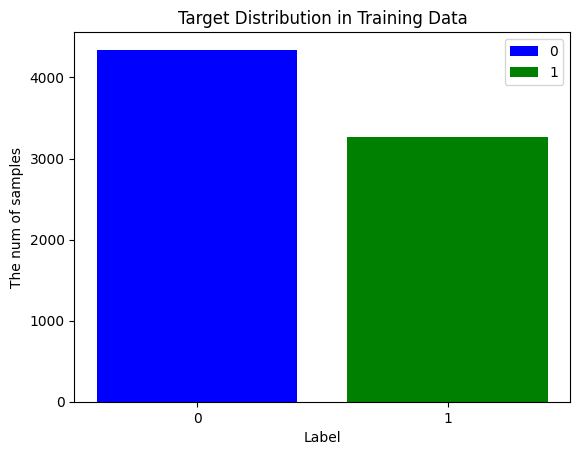

In [8]:
plt.bar([0, 1],df_train['target'].value_counts(), label = [0, 1], color = ['blue', 'green'])
plt.title('Target Distribution in Training Data')
plt.xticks([1,0])
plt.xlabel('Label')
plt.ylabel('The num of samples')
plt.legend()

### Text length distribution

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


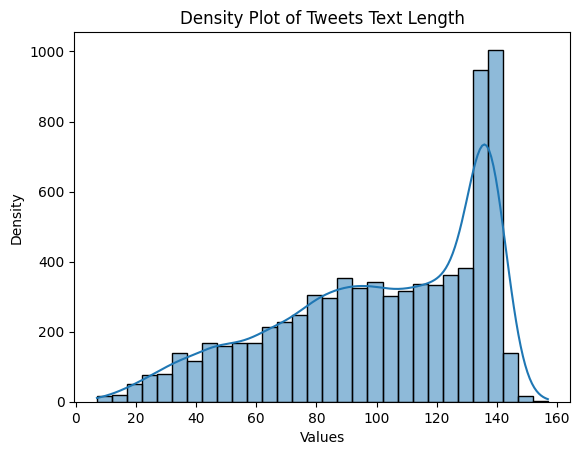

In [9]:
text_len = [len(t) for t in df_train['text']]
sns.histplot(text_len, bins= 30, kde = True)
plt.xlabel('Values')
plt.ylabel('Density')
plt.title('Density Plot of Tweets Text Length')
plt.show()

## 3. Text Pre-Processing

The Tweets are all in string form but the classification algorithem needs it in some sort of feature matrix form. Before converting string to matrix, it's necessary to clean up the text including removing punctuation, numbers, stop words(e.g., 'to', 'the', 'of'). 

In [10]:
import re
import nltk.corpus
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [11]:
# Text processing removing punctuations, numbers and stopwords
# reference https://www.kaggle.com/code/mattison/unsupervised-matrix-factorization?scriptVersionId=99448419&cellId=19
def clean_text(dataframe, text_col):
    '''
    A helper function which takes a dataframe 
    and removes punction and stopwords.
    '''
    #remove all punctuation
    dataframe['no_punct'] = dataframe[text_col].apply(lambda row: re.sub(r'[^\w\s]+', '', row))
    
    #remove numbers 
    dataframe['no_punct_num'] = dataframe['no_punct'].apply(lambda row: re.sub(r'[0-9]+', '', row))
    
    #remove stopwords
    stop_words = stopwords.words('english')
    dataframe['no_stopwords'] = dataframe['no_punct_num'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
    
    #remove extra spaces
    dataframe['clean_text'] = dataframe['no_stopwords'].apply(lambda x: re.sub(' +', ' ', x))
    return 

In [12]:
clean_text(df_train, 'text')

In [13]:
df_train['clean_text'][0]

'Our Deeds Reason earthquake May ALLAH Forgive us'

In [14]:
df_train.head()

,id,keyword,location,text,target,no_punct,no_punct_num,no_stopwords,clean_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds are the Reason of this earthquake Ma...,Our Deeds are the Reason of this earthquake Ma...,Our Deeds Reason earthquake May ALLAH Forgive us,Our Deeds Reason earthquake May ALLAH Forgive us
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask Canada,Forest fire near La Ronge Sask Canada,Forest fire near La Ronge Sask Canada,Forest fire near La Ronge Sask Canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,All residents asked to shelter in place are be...,All residents asked to shelter in place are be...,All residents asked shelter place notified off...,All residents asked shelter place notified off...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfires evacuation orde...,people receive wildfires evacuation orders in...,people receive wildfires evacuation orders Cal...,people receive wildfires evacuation orders Cal...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent this photo from Ruby Alaska as s...,Just got sent this photo from Ruby Alaska as s...,Just got sent photo Ruby Alaska smoke wildfire...,Just got sent photo Ruby Alaska smoke wildfire...


Once the text get cleaned, we will tokenize and lemmatize the text. Tokenize involves splitting a string of words into a list of words. For example "cat sat on dog" would be converted to ['cat', 'sat', 'on', 'dog']. Next, we will lemmatize the text. An example of lemmatizing would be to take the words 'running', 'horses', and 'adjustable', and we lemmatize them to be 'run', 'horse', 'adjust'. This keeps the words general meaning but allows the model to learn better. Additionally, we will ensure that all words are in lowercase form. 

In [15]:
def load_wordnet():
    nltk.download('wordnet')
    
load_wordnet()
# unzip the wordnet.zip file manually
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/co

In [16]:
# reference https://www.kaggle.com/code/mattison/unsupervised-matrix-factorization?scriptVersionId=99448419&cellId=23
def lemmatizer(text):
    ''' 
    A helper function to lemmatize an entire sentence/string
    '''
    lemmatizer = WordNetLemmatizer()
    lemma = [lemmatizer.lemmatize(word.lower()) for word in text] 
    return lemma

def tokenize_lemmatize(dataframe, text_col):
    '''
    A helper function to tokenize then lemmatize the string.
    Also, add column which counts the number of words in that string.
    '''
    dataframe['tokenized'] = dataframe.apply(lambda row: nltk.word_tokenize(row[text_col]), axis=1)
    dataframe['lemmatized'] = dataframe['tokenized'].apply(lambda string: lemmatizer(string))
    dataframe['num_words'] = dataframe['lemmatized'].apply(lambda lst: len(lst))
    dataframe['lemmatized_text'] = dataframe['lemmatized'].apply(lambda x: ' '.join([word for word in x]))
    return

In [17]:
tokenize_lemmatize(df_train, 'clean_text')

In [18]:
df_train.head()

,id,keyword,location,text,target,no_punct,no_punct_num,no_stopwords,clean_text,tokenized,lemmatized,num_words,lemmatized_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds are the Reason of this earthquake Ma...,Our Deeds are the Reason of this earthquake Ma...,Our Deeds Reason earthquake May ALLAH Forgive us,Our Deeds Reason earthquake May ALLAH Forgive us,"[Our, Deeds, Reason, earthquake, May, ALLAH, F...","[our, deed, reason, earthquake, may, allah, fo...",8,our deed reason earthquake may allah forgive u
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask Canada,Forest fire near La Ronge Sask Canada,Forest fire near La Ronge Sask Canada,Forest fire near La Ronge Sask Canada,"[Forest, fire, near, La, Ronge, Sask, Canada]","[forest, fire, near, la, ronge, sask, canada]",7,forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,All residents asked to shelter in place are be...,All residents asked to shelter in place are be...,All residents asked shelter place notified off...,All residents asked shelter place notified off...,"[All, residents, asked, shelter, place, notifi...","[all, resident, asked, shelter, place, notifie...",13,all resident asked shelter place notified offi...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfires evacuation orde...,people receive wildfires evacuation orders in...,people receive wildfires evacuation orders Cal...,people receive wildfires evacuation orders Cal...,"[people, receive, wildfires, evacuation, order...","[people, receive, wildfire, evacuation, order,...",6,people receive wildfire evacuation order calif...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent this photo from Ruby Alaska as s...,Just got sent this photo from Ruby Alaska as s...,Just got sent photo Ruby Alaska smoke wildfire...,Just got sent photo Ruby Alaska smoke wildfire...,"[Just, got, sent, photo, Ruby, Alaska, smoke, ...","[just, got, sent, photo, ruby, alaska, smoke, ...",10,just got sent photo ruby alaska smoke wildfire...


In [19]:
# processing test dataset
clean_text(df_test, 'text')
tokenize_lemmatize(df_test, 'clean_text')

In [20]:
df_test.head()

,id,keyword,location,text,no_punct,no_punct_num,no_stopwords,clean_text,tokenized,lemmatized,num_words,lemmatized_text
0,0,NaN,NaN,Just happened a terrible car crash,Just happened a terrible car crash,Just happened a terrible car crash,Just happened terrible car crash,Just happened terrible car crash,"[Just, happened, terrible, car, crash]","[just, happened, terrible, car, crash]",5,just happened terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",Heard about earthquake is different cities sta...,Heard about earthquake is different cities sta...,Heard earthquake different cities stay safe ev...,Heard earthquake different cities stay safe ev...,"[Heard, earthquake, different, cities, stay, s...","[heard, earthquake, different, city, stay, saf...",7,heard earthquake different city stay safe ever...
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",there is a forest fire at spot pond geese are ...,there is a forest fire at spot pond geese are ...,forest fire spot pond geese fleeing across str...,forest fire spot pond geese fleeing across str...,"[forest, fire, spot, pond, geese, fleeing, acr...","[forest, fire, spot, pond, goose, fleeing, acr...",12,forest fire spot pond goose fleeing across str...
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,Apocalypse lighting Spokane wildfires,Apocalypse lighting Spokane wildfires,Apocalypse lighting Spokane wildfires,Apocalypse lighting Spokane wildfires,"[Apocalypse, lighting, Spokane, wildfires]","[apocalypse, lighting, spokane, wildfire]",4,apocalypse lighting spokane wildfire
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,Typhoon Soudelor kills 28 in China and Taiwan,Typhoon Soudelor kills in China and Taiwan,Typhoon Soudelor kills China Taiwan,Typhoon Soudelor kills China Taiwan,"[Typhoon, Soudelor, kills, China, Taiwan]","[typhoon, soudelor, kill, china, taiwan]",5,typhoon soudelor kill china taiwan


## 4. Transform Text to Matrix

Transform each tweet to a feature vector. The TF-IDF (Term Frequency-Inverse Document Frequency) approach captures the importance of words within a tweet and across the entire dataset, This will creates a tweet-term matrix where rows represent tweets and columns represent unique words. TF-IDF is a bag-of-words approach, which means it does not consider the order of the words in the document. It only considers the frequency of the words in the document and the corpus.

I choose word embedding over TF-IDF as Word embeddings represent words as vectors in a high-dimensional space, where words with similar meanings are clustered together. It captures the semantic meaning of words, which makes them more useful for the tweets classification task. Particularly, I applied **Word2Vec** method.

### Train word2vec model

Word2Vec essentially is a shallow 2-layer neural network trained.
* The input contains all the documents/texts in our training set. For the network to process these texts, they are represented in a 1-hot encoding of the words.
* The number of neurons present in the hidden layer is equal to the length of the embedding we want. That is, if we want all our words to be vectors of length 100, then the hidden layer will contain 100 neurons.
* The output layer contains probabilities for a target word (given an input to the model, what word is expected) given a particular input.
* At the end of the training process, the hidden weights are treated as the word embedding. Intuitively, this can be thought of as each word having a set of n weights (e.g. 100 and 300) “weighing” their different characteristics

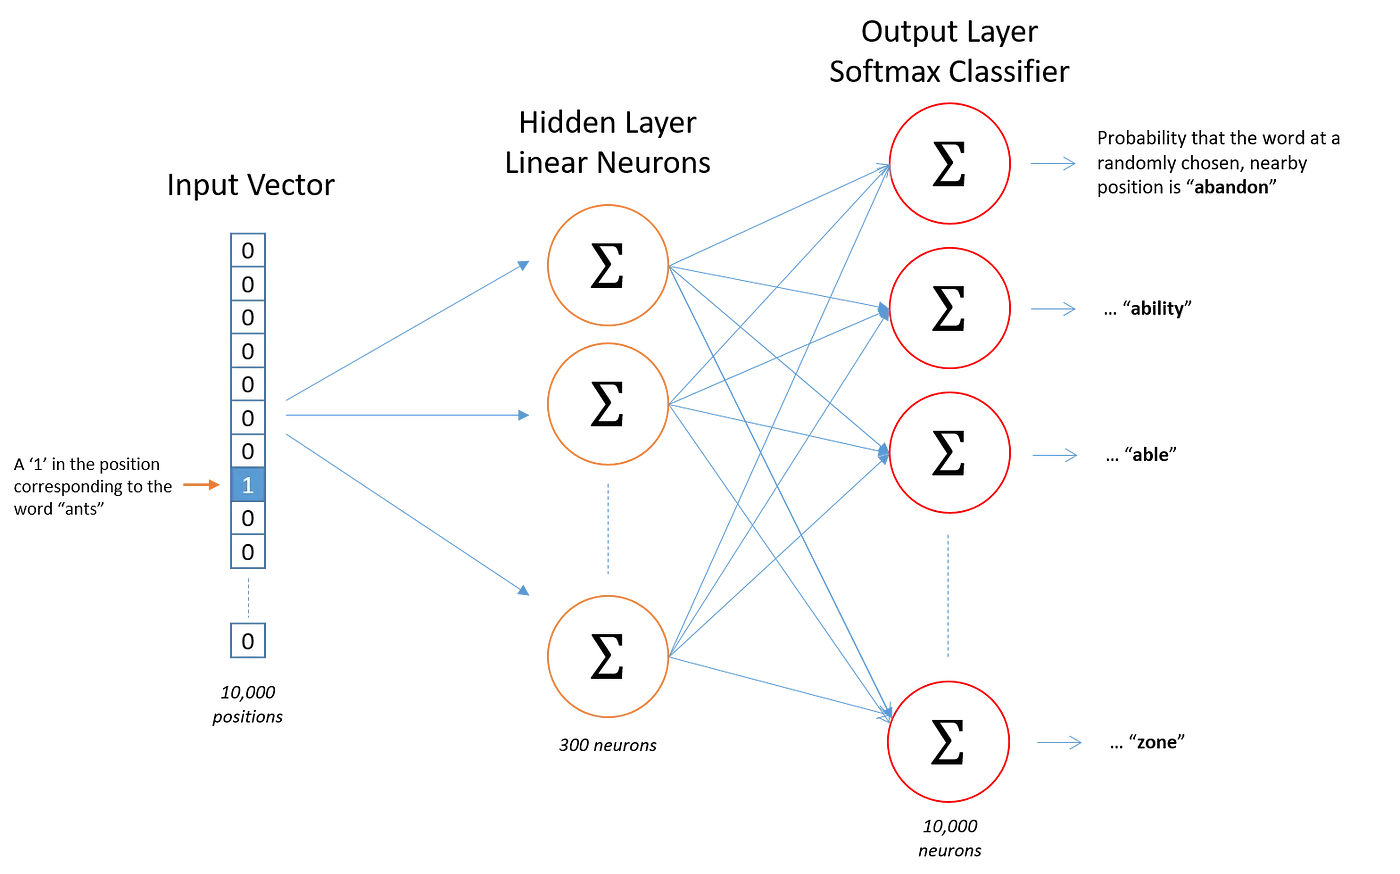
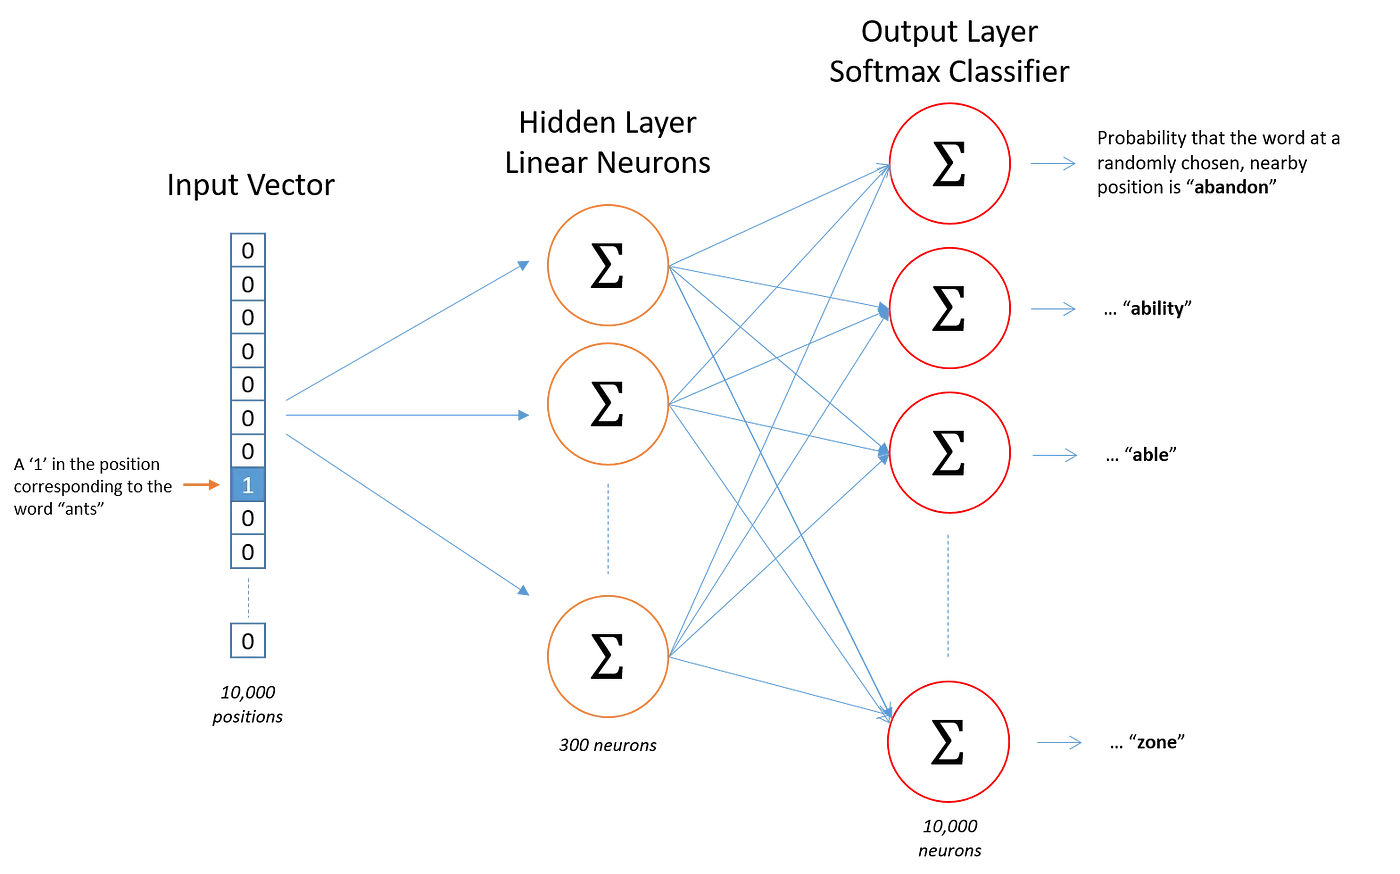

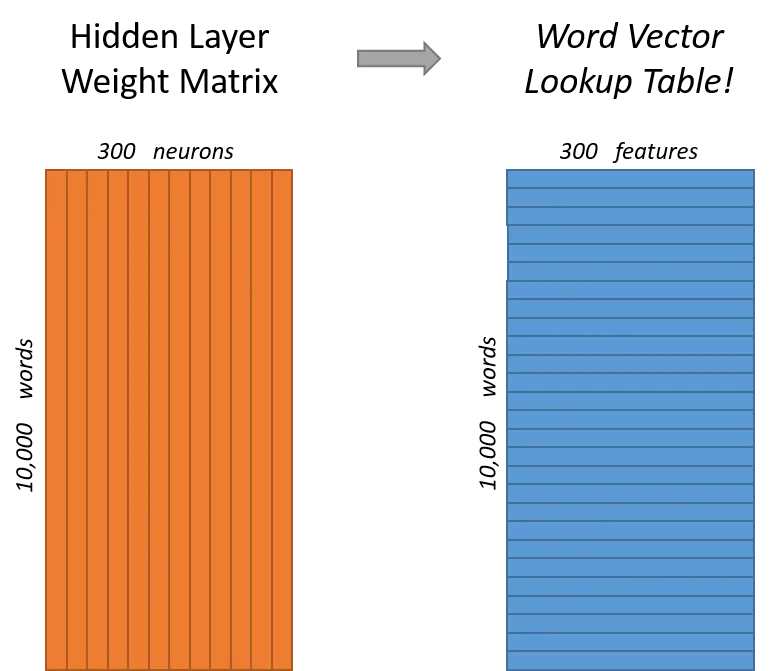

Credit: https://medium.com/@manansuri/a-dummys-guide-to-word2vec-456444f3c673
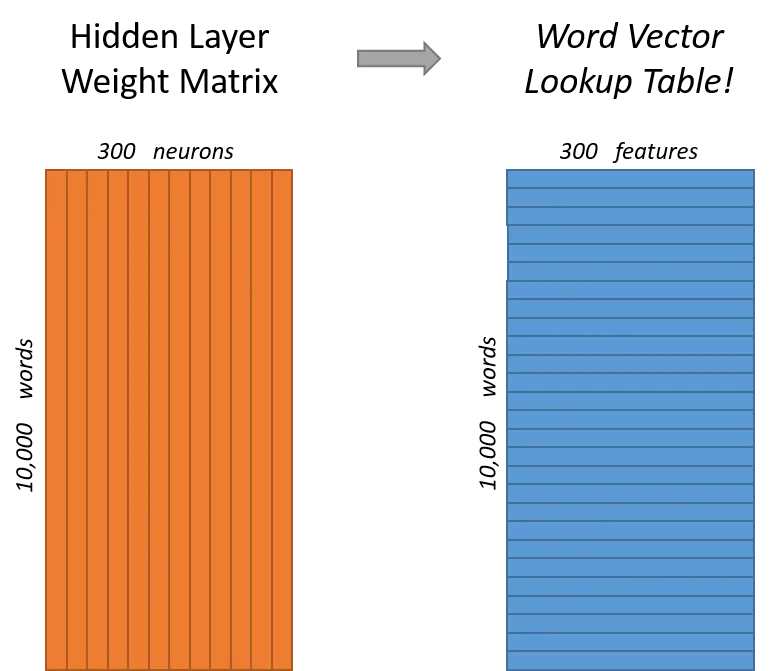

**Model Input**
* Vector_size defines the number of features for each word.
* Window refers to the maximum distance between the current and predicted word within a sentence.
* The min_count parameter is used to set a minimum frequency for the words to be a part of the model: i.e. it ignores all words with count less than min_count.
* Workers refer those many worker threads to train the model.

In [21]:
from gensim.models import Word2Vec

w2v_model = Word2Vec(df_train['lemmatized'], vector_size=100, window=5, min_count=1, workers=4) #text input needs to be list of phrases

In [22]:
# Display a sample word vector
w2v_model.wv['earthquake']

array([-0.02830081,  0.0346373 ,  0.01364569,  0.01008977,  0.00048899,
       -0.0852642 ,  0.01724833,  0.13615274, -0.03606411, -0.04990266,
       -0.01586499, -0.06903998, -0.03430691,  0.0027559 ,  0.01421465,
       -0.02884507,  0.01313602, -0.0567308 ,  0.01952095, -0.09787001,
       -0.00590045,  0.01563299,  0.04963087, -0.02472651,  0.00627438,
       -0.01476896, -0.0476664 , -0.02815007, -0.03603163, -0.01936278,
        0.04688293,  0.01825507,  0.03569482, -0.00623507,  0.00750763,
        0.06002851,  0.01950957, -0.06138585, -0.05759386, -0.09380034,
        0.02307203, -0.01933888, -0.01810435, -0.00439444,  0.03965407,
       -0.02173816, -0.02423791, -0.01354269,  0.02679176,  0.03439083,
        0.02169764, -0.04462177, -0.03354606, -0.02687605, -0.04090245,
        0.02650023,  0.02640612, -0.03209278, -0.03735808,  0.0181471 ,
        0.03600727,  0.02864121,  0.01101147,  0.005288  , -0.0390127 ,
        0.04879316, -0.0054374 ,  0.04896802, -0.04364206,  0.03

In [23]:
# Display similarity of two given words (cosine distance between their vectors)
w2v_model.wv.similarity('earthquake','fire')

0.9867675

### Create Word Embedding Matrix

Tokenizer function explaination:
* fit_on_text: Create a word_index dictionary. The vocabulary index is based on word frequency. The lower integer means more frequent word.
* texts_to_sequence: Transforms each text in texts to a sequence of integers. So it basically takes each word in the text and replaces it with its corresponding integer value from the word_index dictionary.
* pad_sequences: ensure all sequences have the same length

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


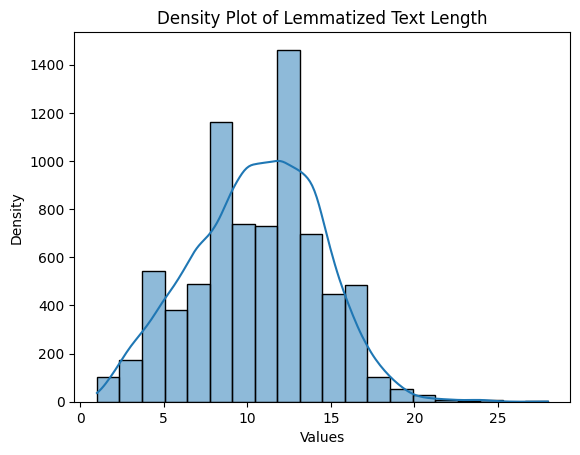

In [24]:
text_len = [len(t) for t in df_train['lemmatized']]
sns.histplot(text_len, bins= 20, kde = True)
plt.xlabel('Values')
plt.ylabel('Density')
plt.title('Density Plot of Lemmatized Text Length')
plt.show()

The majority of lemmatized text in tweets is under 20 words. 

In [59]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tokenize and convert to sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train['lemmatized']) 
sequences = tokenizer.texts_to_sequences(df_train['lemmatized'])
sequences_test = tokenizer.texts_to_sequences(df_test['lemmatized'])
# Padding sequences to ensure all sequences have the same length
padded_sequences = pad_sequences(sequences, maxlen=20, padding='post')
padded_sequences_test = pad_sequences(sequences_test, maxlen=20, padding='post')
# Create embedding matrix
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 100 # same as vector_size in Word2Vec
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]

In [60]:
# The shape of embedding weight matrix
embedding_matrix.shape

(20513, 100)

In [27]:
padded_sequences.shape

(7613, 20)

In [61]:
padded_sequences_test.shape

(3263, 20)

In [62]:
padded_sequences[0]

array([ 620, 4117,  499,  187,   84, 1477, 4118,    9,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0], dtype=int32)

## 5. Split Data into Train and Valid Sets

Use 80% and 20% split between training and validation datasets

In [29]:
from sklearn.model_selection import train_test_split
# train_test_split # stratify=y creates a balanced validation set.
X = padded_sequences
y = df_train['target']
x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=101, stratify=y)

In [30]:
print('Train Data Length:',len(x_train))
print('Validation Data Length:',len(x_val))

Train Data Length: 6090
Validation Data Length: 1523


## 6. Build and Train the Model

In [31]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Embedding, Dropout, Dense, BatchNormalization, GlobalMaxPool1D
# from tensorflow.keras.layers import MaxPooling2D, , Input, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

**Long Short-Term Memory (LSTM)**

The LSTM unit is made up of four feedforward neural networks. Each of these neural networks consists of an input layer and an output layer. In each of these neural networks, input neurons are connected to all output neurons. As a result, the LSTM unit has four fully connected layers.
Three of them is having sigmoid activation function (output will be 0 or 1) and one is having tanh activation function( output will range from -1 to 1).

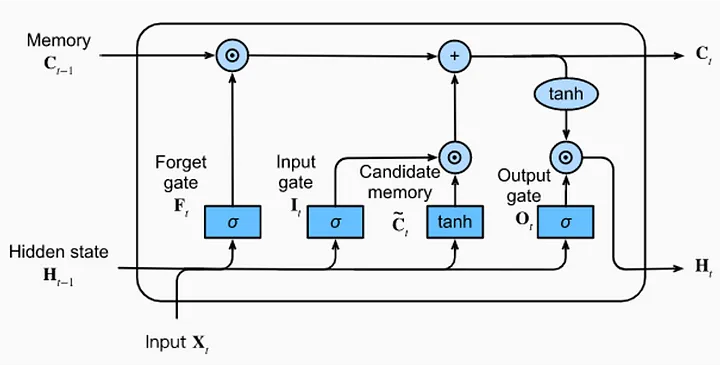

Credits: https://d2l.ai/chapter_recurrent-modern/lstm.html
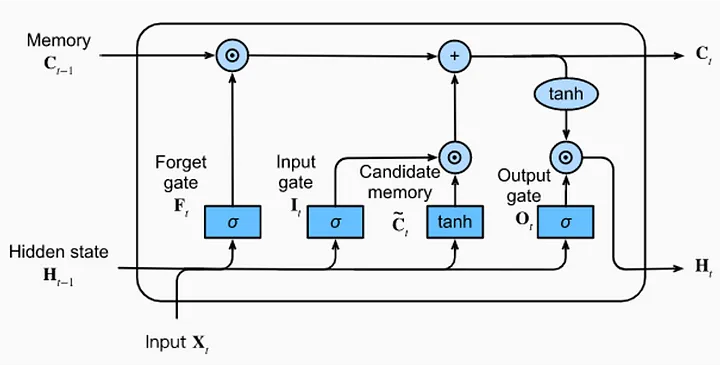

The three gates (forget gate, input gate and output gate) are information selectors.
* Forget Gate: The forget gate decides (based on X_[t] and H_[t−1] vectors) what information to remove from the cell state vector coming from time t− 1.
* Candidate memory: he candidate memory is responsible for the generation of a vector of information that is candidate to be added to the cell state. Candidate memory output neurons use hyperbolic tangent function. The properties of this function ensure that all values of the candidate vector are between -1 and 1. This is used to normalize the information that will be added to the cell state.
  
* Input Gate: The input gate is responsible for the generation of a selector vector which will be multiplied elementwise with the candidate vector.
* Output Gate: The output gate determines the value of the hidden state outputted by the LSTM (in instant t) and received by the LSTM in the next instant (t+ 1) input set.

**Model 1**

After some trial and error on model architecture and hyper parameters, I find that the following model has decent performance.

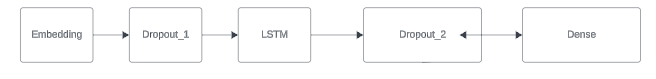

In [32]:
# Build the model
lstm_out = 64
model1 = Sequential()
model1.add(Embedding(input_dim=vocab_size,
                    output_dim=embedding_dim,
                    weights=[embedding_matrix],
                    trainable=True)) 
model1.add(Dropout(0.2))
model1.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.4))
model1.add(Dropout(0.5))
model1.add(Dense(1, activation='sigmoid'))
model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │       2,051,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,051,300 (7.83 MB)

 Trainable params: 2,051,300 (7.83 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:
# Compile the model
model1.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

In [34]:

early_stop = EarlyStopping(monitor = 'val_loss', patience = 3, 
                           verbose = 1, restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, 
                                   verbose=1, min_lr=0.00001)
callbacks_list = [early_stop, reduce_lr]

In [35]:
history1 = model1.fit(x_train, y_train,
                    epochs=10, validation_data = (x_val, y_val), verbose=1,
                     callbacks=callbacks_list)

Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - accuracy: 0.5628 - loss: 0.6892 - val_accuracy: 0.5706 - val_loss: 0.6826 - learning_rate: 1.0000e-04
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.5603 - loss: 0.6826 - val_accuracy: 0.5706 - val_loss: 0.6770 - learning_rate: 1.0000e-04
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.5834 - loss: 0.6650 - val_accuracy: 0.7695 - val_loss: 0.5393 - learning_rate: 1.0000e-04
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.7892 - loss: 0.5039 - val_accuracy: 0.7945 - val_loss: 0.4618 - learning_rate: 1.0000e-04
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.8389 - loss: 0.4114 - val_accuracy: 0.7978 - val_loss: 0.4620 - learning_rate: 1.0000e-04
Epoch 6/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.8769 - loss: 0.3501 - val_accuracy: 0.8024 - val_loss: 0.4694 - learning_rate: 1.0000e-04
Epoch 7/10
190/191 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - ac

In [36]:
model1_hist = pd.DataFrame(model1.history.history)
max_val_acc1 = model1_hist.val_accuracy.max()
print('Maximum Validation Acc:', round(max_val_acc1 * 100, 2), "%")
min_val_loss1 = model1_hist.val_loss.min()
print('Minimum Validation Loss:', round(min_val_loss1 * 100, 2), "%")

Maximum Validation Acc: 80.24 %
Minimum Validation Loss: 46.18 %


In [46]:
def plot(history, arr):
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))
    for idx in range(2):
        ax[idx].plot(history.history[arr[idx][0]])
        ax[idx].plot(history.history[arr[idx][1]])
        ax[idx].legend([arr[idx][0], arr[idx][1]],fontsize=18)
        ax[idx].set_xlabel('Epoch ',fontsize=16)
        ax[idx].set_ylabel('Loss or Acc',fontsize=16)
        ax[idx].set_title(arr[idx][0] + ' X ' + arr[idx][1],fontsize=16)

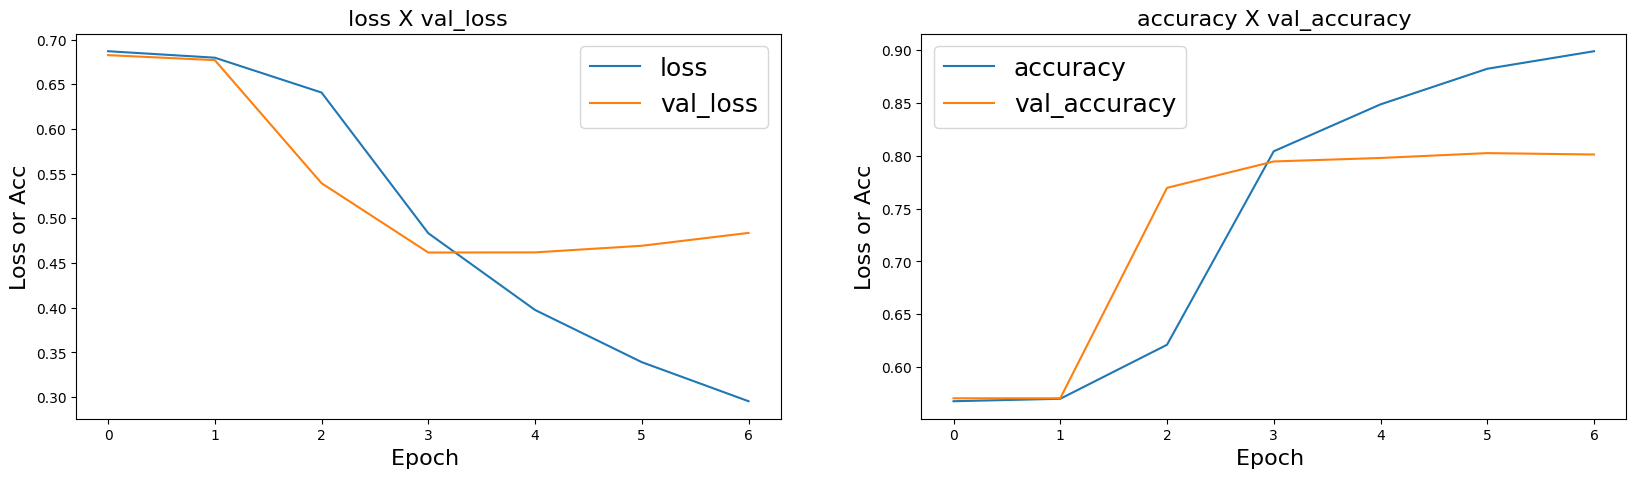

In [47]:
plot(history1, [['loss', 'val_loss'],['accuracy', 'val_accuracy']])

In [55]:
from sklearn.metrics import classification_report
y_pred1 = (model1.predict(x_val) > 0.5).astype("int32") # convert probability to binary class
print(classification_report(y_val, y_pred1))

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
              precision    recall  f1-score   support

           0       0.79      0.88      0.83       869
           1       0.81      0.69      0.74       654

    accuracy                           0.79      1523
   macro avg       0.80      0.78      0.79      1523
weighted avg       0.80      0.79      0.79      1523



**Model 2**

The history of first model indicates some overfiting on training data. 
* Reduce the number of units in LSTM from 64 to 32.
* Added a batchnormalization layer


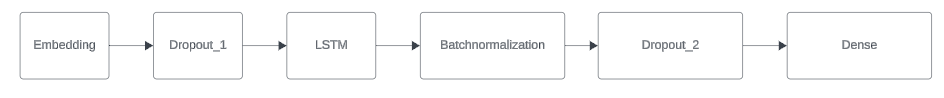

In [37]:
# Build the model
lstm_out = 32
model2 = Sequential()
model2.add(Embedding(input_dim=vocab_size,
                    output_dim=embedding_dim,
                    weights=[embedding_matrix],
                    trainable=True)) 

model2.add(Dropout(0.2))
model2.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.4))
model2.add(BatchNormalization())
model2.add(Dropout(0.5))
model2.add(Dense(1, activation='sigmoid'))
model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │       2,051,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,051,300 (7.83 MB)

 Trainable params: 2,051,300 (7.83 MB)

 Non-trainable params: 0 (0.00 B)

In [38]:
# Compile the model
model2.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

In [39]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 3, 
                           verbose = 1, restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, 
                                   verbose=1, min_lr=0.00001)
callbacks_list = [early_stop, reduce_lr]

In [40]:
history2 = model2.fit(x_train, y_train,
                    epochs=10, validation_data = (x_val, y_val), verbose=1,
                     callbacks=callbacks_list)

Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - accuracy: 0.5480 - loss: 0.7242 - val_accuracy: 0.5706 - val_loss: 0.6883 - learning_rate: 1.0000e-04
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.5589 - loss: 0.7021 - val_accuracy: 0.5752 - val_loss: 0.6817 - learning_rate: 1.0000e-04
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.5912 - loss: 0.6837 - val_accuracy: 0.6139 - val_loss: 0.6666 - learning_rate: 1.0000e-04
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.6301 - loss: 0.6529 - val_accuracy: 0.7039 - val_loss: 0.6266 - learning_rate: 1.0000e-04
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.7077 - loss: 0.5968 - val_accuracy: 0.7728 - val_loss: 0.5517 - learning_rate: 1.0000e-04
Epoch 6/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.7799 - loss: 0.5026 - val_accuracy: 0.7984 - val_loss: 0.4807 - learning_rate: 1.0000e-04
Epoch 7/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - acc

In [41]:
model2_hist = pd.DataFrame(model2.history.history)
max_val_acc1 = model2_hist.val_accuracy.max()
print('Maximum Validation Acc:', round(max_val_acc1 * 100, 2), "%")
min_val_loss1 = model2_hist.val_loss.min()
print('Minimum Validation Loss:', round(min_val_loss1 * 100, 2), "%")

Maximum Validation Acc: 80.04 %
Minimum Validation Loss: 45.36 %


In [43]:
def plot(history, arr):
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))
    for idx in range(2):
        ax[idx].plot(history.history[arr[idx][0]])
        ax[idx].plot(history.history[arr[idx][1]])
        ax[idx].legend([arr[idx][0], arr[idx][1]],fontsize=18)
        ax[idx].set_xlabel('Epoch ',fontsize=16)
        ax[idx].set_ylabel('Loss or Acc',fontsize=16)
        ax[idx].set_title(arr[idx][0] + ' X ' + arr[idx][1],fontsize=16)

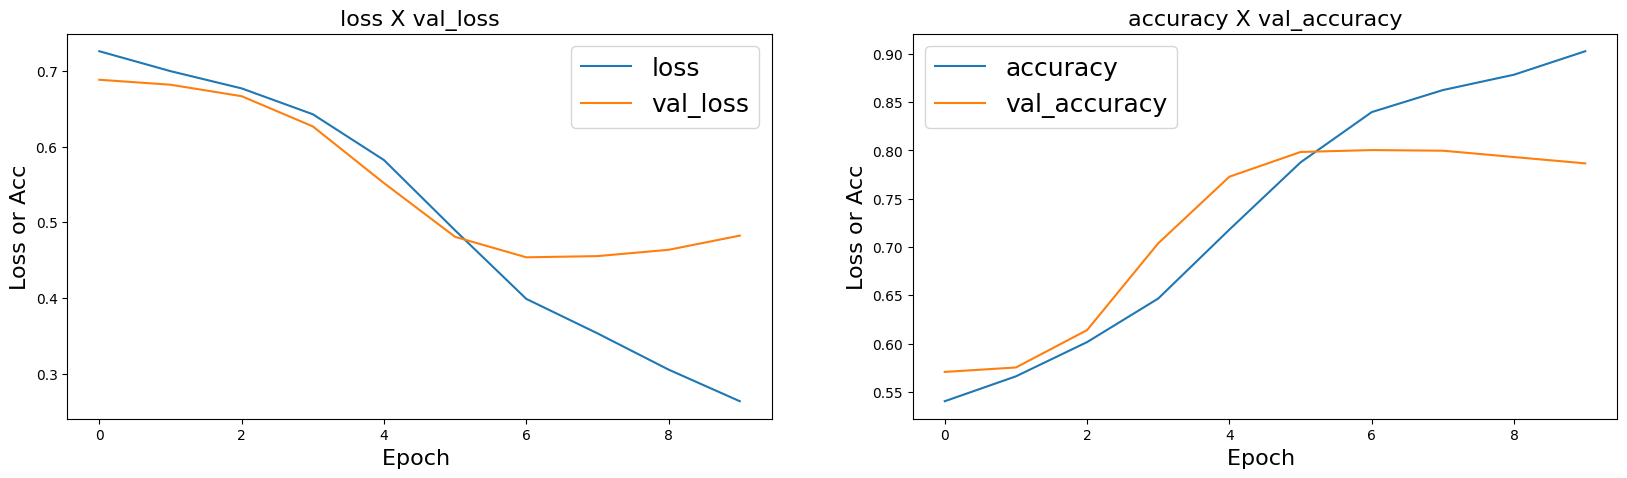

In [44]:
plot(history2, [['loss', 'val_loss'],['accuracy', 'val_accuracy']])

In [57]:
y_pred2 = (model2.predict(x_val) > 0.5).astype("int32") # convert probability to binary class
print(classification_report(y_val, y_pred2))

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
              precision    recall  f1-score   support

           0       0.79      0.89      0.84       869
           1       0.82      0.69      0.75       654

    accuracy                           0.80      1523
   macro avg       0.80      0.79      0.79      1523
weighted avg       0.80      0.80      0.80      1523



Although the two model has similar results in accuracy and loss, the result of sceond model is more stable than the firt one as the loss between train and valid data diverge later so does the accuracy. More research on model architecture is needed to further improve the loss and accuracy. 

In [48]:
# Save the model
model2.save('model2.keras')

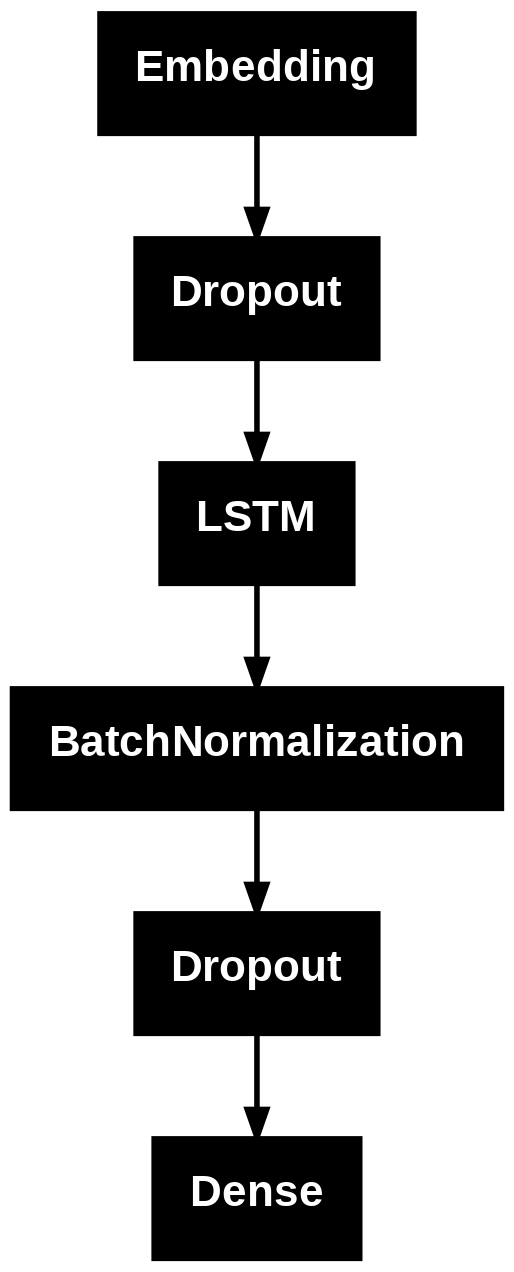

In [45]:
plot_model(model2, to_file='model2.png')

## 7. Submission

In [63]:
# Binary classification of test data
y_pred = (model2.predict(padded_sequences_test) > 0.5).astype("int32") # convert probability to binary class

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


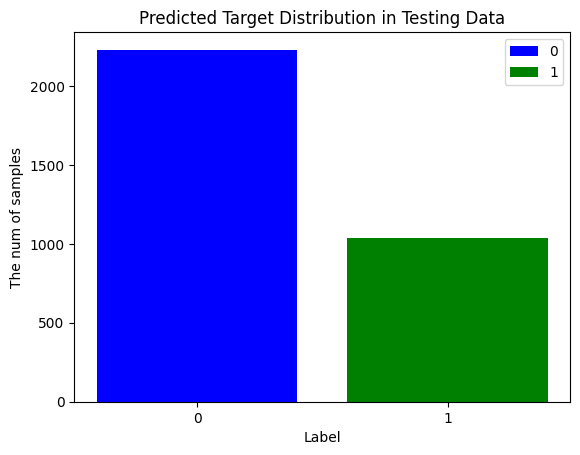

In [84]:
# Distribution of predicted target in testing data
plt.bar([0, 1],pd.Series(y_pred.flatten()).value_counts(), label = [0, 1], color = ['blue', 'green'])
plt.title('Predicted Target Distribution in Testing Data')
plt.xticks([1,0])
plt.xlabel('Label')
plt.ylabel('The num of samples')
plt.legend()

In [79]:
submission = pd.DataFrame({'id': df_test['id'],
                          'target': y_pred.flatten()}).set_index('id') # flatten y_pred to make it 1-d column
submission.to_csv("submission.csv") 

## Reference
Word2Vec: https://medium.com/@manansuri/a-dummys-guide-to-word2vec-456444f3c673

LSTM: https://medium.com/@ottaviocalzone/an-intuitive-explanation-of-lstm-a035eb6ab42c